# ライブラリの準備

In [ ]:
!pip install kaggle timm

In [1]:
import pandas as pd
import random
import numpy as np
from google.colab import files
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import timm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# データセットのダウンロード

In [ ]:
# kaggleのAPI認証
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#データセットをダウンロード
if not os.path.exists('/content/k3-competition-2024.zip'):
    !kaggle competitions download -c k3-competition-2024
    !unzip -q /content/k3-competition-2024.zip -d /content/k3-competition-2024/

# パラメータの定義

In [2]:
# 定数の定義
TRAIN_DIR_PATH = '/content/k3-competition-2024/train/'
TEST_DIR_PATH = '/content/k3-competition-2024/test/'

# 各ラベル確認する画像の枚数
CONFIRM_NUM = 5

# 前処理に関するハイパラ
SEED_VALUE = 42
VALID_SIZE = 0.01
INPUT_SIZE = 224

# 学習に関するハイパラ
MODEL_NAME = 'vit_base_patch16_224.augreg2_in21k_ft_in1k'
LEARNING_RATE = 1e-5
EPOCHS = 20
BATCH_SIZE = 64

In [3]:
def set_seed(seed=SEED_VALUE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# シード値の固定
set_seed()

# データセットの準備

In [4]:
# データの読み込み
df = pd.read_csv('/content/k3-competition-2024/train.csv')

# ラベルIDとラベルの確認
dict(sorted(zip(df['label_id'].unique(), df['label'].unique())))

{0: 'burj_khalifa',
 1: 'chichen_itza',
 2: 'christ_the_reedemer',
 3: 'eiffel_tower',
 4: 'great_wall_of_china',
 5: 'machu_pichu',
 6: 'pyramids_of_giza',
 7: 'roman_colosseum',
 8: 'statue_of_liberty',
 9: 'stonehenge',
 10: 'taj_mahal',
 11: 'venezuela_angel_falls'}

In [5]:
def create_train_path(row):
    ''' 学習データのパスを作成する関数
    '''
    return os.path.join(TRAIN_DIR_PATH, row['label'], row['image'])

# 各データのパスの格納
df['path'] = df.apply(create_train_path, axis=1)

In [6]:
# 学習データと検証データに分割
train_df, valid_df = train_test_split(df,
                                      test_size=VALID_SIZE,
                                      shuffle=True,
                                      random_state=SEED_VALUE,
                                      stratify=df['label_id'])

# インデックス降り直し
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [7]:
# 学習データのサイズ確認
print(len(train_df))
print(train_df['label'].value_counts())

1903
label
roman_colosseum          195
machu_pichu              194
great_wall_of_china      194
eiffel_tower             194
burj_khalifa             193
pyramids_of_giza         184
chichen_itza             168
christ_the_reedemer      160
venezuela_angel_falls    124
statue_of_liberty        118
stonehenge               101
taj_mahal                 78
Name: count, dtype: int64


In [8]:
# 検証データのサイズ確認
print(len(valid_df))
print(valid_df['label'].value_counts())

20
label
christ_the_reedemer      2
chichen_itza             2
pyramids_of_giza         2
machu_pichu              2
great_wall_of_china      2
roman_colosseum          2
burj_khalifa             2
eiffel_tower             2
stonehenge               1
venezuela_angel_falls    1
statue_of_liberty        1
taj_mahal                1
Name: count, dtype: int64


# Transform・Dataset・DataLoaderの作成

In [9]:
class TrainTransforms:
    ''' 学習データをモデルへ入力する際に適応する変換(前処理 + Online Augmentation)
    '''
    def __init__(self, input_size):
        self.transforms = transforms.Compose(
            [
                transforms.RandAugment(5, 15),
                transforms.AugMix(3, 3),
                transforms.Resize((input_size,input_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
            ]
        )

    def __call__(self, image):
        return self.transforms(image)

In [10]:
class TestTransforms:
    ''' 検証・テストデータをモデルへ入力する際に適応する変換(前処理)
    '''
    def __init__(self, input_size):
        self.transforms = transforms.Compose(
            [
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
            ]
        )

    def __call__(self, image):
        return self.transforms(image)

In [11]:
class TrainDataset(Dataset):
    ''' 学習データのDataset
    '''
    def __init__(self, paths, labels, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        label = self.labels[index]

        image = Image.open(path)
        image = self.transform(image)

        return image, label

In [12]:
# データセットの作成
train_dataset = TrainDataset(train_df['path'], train_df['label_id'], TrainTransforms(input_size=INPUT_SIZE))
valid_dataset = TrainDataset(valid_df['path'], valid_df['label_id'], TestTransforms(input_size=INPUT_SIZE))

# データローダーの作成
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

# モデルの準備

In [13]:
# モデルの定義
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=df['label'].nunique())

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

# 学習

In [14]:
def train(model, train_dataloader, valid_dataloader, optimizer, criterion, epochs):
    ''' 学習及び検証を行う
    '''
    model = torch.nn.DataParallel(model)
    # モデルをGPU(CPU)に乗せる
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f'使用デバイス：{device}')

    # 高速化設定
    torch.backends.cudnn.benchmark = True
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = torch.cuda.amp.GradScaler(2**12)

    # エポック処理
    print('Start training...')
    best_model_state = model.state_dict()
    best_loss = 100.0
    loss_history, f1_history = {'train': [], 'valid': []}, {'train': [], 'valid': []}

    for epoch in range(epochs):
        print(f'\nepoch [{epoch+1}/{epochs}]')

        # 学習フェーズ ---------------------
        model.train()
        epoch_preds, epoch_labels = [], []
        epoch_losses = 0.0

        # バッチ処理
        for images, labels in tqdm(train_dataloader):
            # データをGPU(CPU)に乗せる
            images = images.to(device)
            labels = labels.to(device)

            # optimizerの初期化
            optimizer.zero_grad()

            # forward(予測)
            with torch.autocast(device_type=device.type):
                preds_proba = model(images)
                loss = criterion(preds_proba, labels)

            # backward(重みの最適化)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # 1エポックの総損失の更新
            epoch_losses += loss.item()

            # 1バッチの予測ラベルと正解ラベルの記録
            preds = torch.argmax(preds_proba, dim=1)
            epoch_preds.append(preds.cpu().detach())
            epoch_labels.append(labels.cpu().detach())

            # 一時変数の削除
            del preds_proba, preds, loss, images, labels

        # 各バッチの予測ラベルと正解ラベルを1つのテンソルに平坦化
        epoch_preds = torch.cat(epoch_preds, 0)
        epoch_labels = torch.cat(epoch_labels, 0)

        # 1エポックの平均損失とmacro-F1の算出
        epoch_losses /= len(train_dataloader)
        epoch_f1 = f1_score(epoch_preds, epoch_labels, average='macro')

        # 1エポックの平均損失とmacro-F1の記録
        loss_history['train'].append(epoch_losses)
        f1_history['train'].append(epoch_f1)

        # 検証フェーズ ---------------------
        model.eval()
        epoch_preds, epoch_labels = [], []
        epoch_losses = 0.0

        # バッチ処理(微分・重みの更新を行わない)
        with torch.inference_mode():
            for images, labels in tqdm(valid_dataloader):
                images = images.to(device)
                labels = labels.to(device)

                # forward(予測)
                with torch.autocast(device_type=device.type):
                    preds_proba = model(images)
                    loss = criterion(preds_proba, labels)

                # 1エポックの総損失の更新
                epoch_losses += loss.item()

                # 1バッチの予測ラベルと正解ラベルの記録
                preds = torch.argmax(preds_proba, dim=1)
                epoch_preds.append(preds.cpu().detach())
                epoch_labels.append(labels.cpu().detach())

                # 一時変数の削除
                del preds_proba, preds, loss, images, labels

            # 各バッチの予測ラベルと正解ラベルを1つのテンソルに平坦化
            epoch_preds = torch.cat(epoch_preds, 0)
            epoch_labels = torch.cat(epoch_labels, 0)

            # 1エポックの平均損失とmacro-F1の算出
            epoch_losses /= len(valid_dataloader)
            epoch_f1 = f1_score(epoch_preds, epoch_labels, average='macro')

            # 1エポックの平均損失とmacro-F1の記録
            loss_history['valid'].append(epoch_losses)
            f1_history['valid'].append(epoch_f1)

        # 最良モデルの保存
        if best_loss > loss_history["valid"][-1]:
            best_model_state = model.state_dict()
            best_loss = loss_history["valid"][-1]

        print(f'train_loss:{loss_history["train"][-1]:4f}, train_f1:{f1_history["train"][-1]:4f}')
        print(f'valid_loss:{loss_history["valid"][-1]:4f}, valid_f1:{f1_history["valid"][-1]:4f}')

    # 最良モデルの読み込み
    model.load_state_dict(best_model_state)

    print('Finish training!')
    return model, loss_history, f1_history

In [15]:
num_images = []
for count in train_df['label'].value_counts():
    num_images.append(count)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
weights = 1.0 / torch.tensor(num_images).to(device)

In [16]:
# 最適化器・損失関数の定義
optimizer = torch.optim.RAdam(params=model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss(weights)

# 学習
model, loss_history, f1_history = train(model, train_dataloader, valid_dataloader, optimizer, criterion, EPOCHS)

使用デバイス：cuda:0
Start training...

epoch [1/20]


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


train_loss:2.801720, train_f1:0.053907
valid_loss:2.591136, valid_f1:0.041667

epoch [2/20]


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


train_loss:2.473592, train_f1:0.124608
valid_loss:2.197144, valid_f1:0.150000

epoch [3/20]


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


train_loss:2.053157, train_f1:0.311037
valid_loss:1.725089, valid_f1:0.463889

epoch [4/20]


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


train_loss:1.432398, train_f1:0.584434
valid_loss:1.042072, valid_f1:0.733333

epoch [5/20]


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


train_loss:0.727902, train_f1:0.813938
valid_loss:0.507948, valid_f1:0.861111

epoch [6/20]


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


train_loss:0.393142, train_f1:0.893967
valid_loss:0.301027, valid_f1:0.900000

epoch [7/20]


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


train_loss:0.263288, train_f1:0.931559
valid_loss:0.197006, valid_f1:0.900000

epoch [8/20]


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


train_loss:0.200457, train_f1:0.943640
valid_loss:0.156167, valid_f1:0.900000

epoch [9/20]


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


train_loss:0.162619, train_f1:0.952898
valid_loss:0.129899, valid_f1:0.900000

epoch [10/20]


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


train_loss:0.140397, train_f1:0.958299
valid_loss:0.112630, valid_f1:0.900000

epoch [11/20]


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


train_loss:0.116016, train_f1:0.965022
valid_loss:0.085096, valid_f1:0.900000

epoch [12/20]


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


train_loss:0.098392, train_f1:0.972534
valid_loss:0.067221, valid_f1:0.900000

epoch [13/20]


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


train_loss:0.074955, train_f1:0.981102
valid_loss:0.051332, valid_f1:1.000000

epoch [14/20]


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


train_loss:0.080920, train_f1:0.976776
valid_loss:0.061720, valid_f1:0.900000

epoch [15/20]


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


train_loss:0.058763, train_f1:0.982620
valid_loss:0.052651, valid_f1:1.000000

epoch [16/20]


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


train_loss:0.048669, train_f1:0.987989
valid_loss:0.062286, valid_f1:0.900000

epoch [17/20]


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


train_loss:0.050428, train_f1:0.987661
valid_loss:0.040957, valid_f1:1.000000

epoch [18/20]


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


train_loss:0.045167, train_f1:0.988262
valid_loss:0.050410, valid_f1:0.900000

epoch [19/20]


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


train_loss:0.036308, train_f1:0.991975
valid_loss:0.032905, valid_f1:1.000000

epoch [20/20]


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

train_loss:0.042426, train_f1:0.985931
valid_loss:0.027886, valid_f1:1.000000
Finish training!


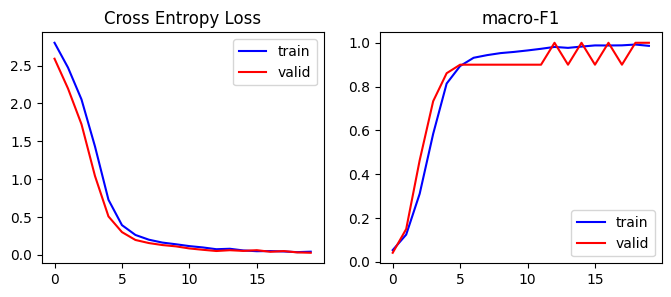

In [17]:
# 学習曲線の表示
plt.figure(figsize=(4*2, 3))

plt.subplot(121)
plt.plot(loss_history['train'], label='train', c='b')
plt.plot(loss_history['valid'], label='valid', c='r')
plt.title('Cross Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(f1_history['train'], label='train', c='b')
plt.plot(f1_history['valid'], label='valid', c='r')
plt.title('macro-F1')
plt.legend()

plt.show()

In [18]:
# モデルを保存
torch.save(model.cpu().state_dict(), f'/content/model.pth')

# テストデータの予測

In [19]:
# データの読み込み
test_df = pd.read_csv('/content/k3-competition-2024/test.csv')

In [20]:
def create_test_path(row):
    ''' テストデータのパスを作成する関数
    '''
    return os.path.join(TEST_DIR_PATH, row['image'])

# 各データのパスの格納
test_df['path'] = test_df.apply(create_test_path, axis=1)

In [21]:
class TestDataset(Dataset):
    ''' テストデータのDataset
    '''
    def __init__(self, paths, transform):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]

        image = Image.open(path)
        image = self.transform(image)

        return image

In [22]:
# データセットの作成
test_dataset = TestDataset(test_df['path'], TestTransforms(input_size=INPUT_SIZE))

# データローダーの作成
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [23]:
def test(model, test_dataloader):
    ''' テストを行う
    '''
    # モデルをGPU(CPU)に乗せる
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f'使用デバイス：{device}')

    # 予測フェーズ ---------------------
    print('Start testing...')
    model.eval()
    labels = []

    # バッチ処理(微分・重みの更新を行わない)
    with torch.inference_mode():
        for images in tqdm(test_dataloader):
            # データをGPU(CPU)に乗せる
            images = images.to(device, non_blocking=True)

            # forward(予測)
            preds_proba = model(images)

            # 予測ラベルの記録
            preds = torch.argmax(preds_proba, dim=1)
            labels.append(preds.cpu().detach())

        # 各バッチの予測ラベルを1つのテンソルに平坦化
        labels = torch.cat(labels, 0)

    print('Finish testing!')
    return labels

In [24]:
# テストデータの予測
labels = test(model, test_dataloader)

# submission.csvの書き出し
sample_df = pd.read_csv('/content/k3-competition-2024/sample_submission.csv')
sample_df['label_id'] = labels
sample_df.to_csv(f'/content/submission.csv', index=False, header=True)

使用デバイス：cuda:0
Start testing...


100%|██████████| 31/31 [00:38<00:00,  1.23s/it]

Finish testing!
